<a href="https://colab.research.google.com/github/voke-brume/AI-ML/blob/main/ML/MultivariateTimeSeriesAnalysis/VARvsLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MULTIVARIATE TIME SERIES ANALYSIS: VECTOR AUTOREGRESSIVE MODEL (VAR) VS ML MODEL** 
by Voke Brume

CS573 - Prof Omid Dezhangi

In [ ]:
# Import required libraries
import os
import copy
import random

import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from matplotlib import pyplot as plt
from sklearn import preprocessing
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

## **INTRODUCTION**

This report is a time series extension of the previous report on Bayes Multivariate Discriminant Classifier. Unlike the previous report, each sample for each subject will be considered as a valid continuous sample that will not be averaged or aggregated. The concatenated data is then explored and visualized.The cleaned data is then fed into an Exponential smoothing model and a ML model for comparison.

### **FUNCTIONS FOR ANALYSIS**

In [ ]:
# FUNCTIONS FOR ANALYSIS

# Function to save the names of specified file type in a path
# @param: path
# @return: list of files in path
def file_list(path):
  return os.listdir(os.path.abspath(path))

# Function to read .csv file
# @param: path, file_name
# return: read file
def read_csv_file(path, file_name):
  return pd.read_csv(path + file_name)

# Function to concatenate files of specific type in a location
# @param: path, file_list, file_type, axis
# @return: file containing all files in location
def concat_files(path, file_list, file_type, axis):
  # Create temp file to add other files into
  temp_file = pd.DataFrame()
  # Loop through files and concatenate them into master 
  # file for respective class
  for file in file_list:
    if file.endswith(file_type):
      data = pd.read_csv(path + file)
      temp_file = pd.concat([temp_file, data], axis, ignore_index = True)
  return temp_file

# Function to add new column to the specified index and fill with 
# values in existing file
# @param: dataframe, label_name, label
# @return: dataframe with inserted column and labels
def add_column(dataframe, label_name, label, index_position):
  return dataframe.insert(index_position, label_name, label)

# Function to add labels
# @param: dataframe
# @returns: labeled daraframe
def add_labels(dataframe, label):
  temp_list = pd.Series([])
  for i in range(dataframe.shape[0]):
    temp_list[i] = label
  return temp_list

# Function to drop specified columns in dataframe
# @param: dataframe
# Inplace mutation
def drop_column(dataframe, rows, columns):
  dataframe.drop(dataframe.iloc[ :, 13 : -10 ], inplace=True, axis=1)

## **DATA**

The data consists of multiple .csv files  differentiated into 'R' and 'NR" classes. Each .csv file belongs to a subject and contains multiple time series samples. These files are read in and preprocessed according to their statistical attributes before analysis.

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **DATA INVESTIGATION AND PREPROCESSING**

This section shows investigation and visualization of the data to determine the best approaches for preprocessing. To aid investigation and visualization, the files are concatenated into one file, after which their spread is then analysed using visualization tools. 

For this analysis, columns labelled Morning_Question1 through Afternoon_Question7 may be referred to as columns B-N and columns labelled HR_mean through Stress_Ku may be referred to as columns IQ-IZ.

The data files are read in and concatenated into master files. The master files are then inspected to ensure the process went well and the resulting master files do not contain impurities such as null values.

In [ ]:
# Save path for repetitive use
path_R = "/content/drive/Othercomputers/myPCWindows/schoolStuff [D]/CS573/assignments/assignment02/Data/Data/Opioid/ChunkedData_R/"
path_NR = "/content/drive/Othercomputers/myPCWindows/schoolStuff [D]/CS573/assignments/assignment02/Data/Data/Opioid/chunkedData_NR/"

Each file in class R and NR contain 260 columns which means a master file can be created by concatenating files in respective classes across the 0 axis (columns).

In [ ]:
# Save and print names of all files in directory
file_list_R = file_list(path_R)
file_list_NR = file_list(path_NR)
print(file_list_R)
print(file_list_NR)

['Daily_2009_S1.csv', 'Daily_2009_S2.csv', 'Daily_2009_S3.csv', 'Daily_2027_S1.csv', 'Daily_2027_S2.csv', 'Daily_2027_S3.csv', 'Daily_2060_S1.csv', 'Daily_2060_S2.csv', 'Daily_2060_S3.csv', 'Daily_2061_S1.csv', 'Daily_2061_S2.csv', 'Daily_2061_S3.csv', 'Daily_2088_S2.csv', 'Daily_2088_S3.csv']
['Daily_2002_S2.csv', 'Daily_2002_S3.csv', 'Daily_2018_S1.csv', 'Daily_2018_S2.csv', 'Daily_2018_S3.csv', 'Daily_2029_S1.csv', 'Daily_2029_S2.csv', 'Daily_2029_S3.csv', 'Daily_2052_S1.csv', 'Daily_2052_S2.csv', 'Daily_2052_S3.csv', 'Daily_2057_S1.csv', 'Daily_2057_S2.csv', 'Daily_2057_S3.csv', 'Daily_2065_S1.csv', 'Daily_2065_S2.csv', 'Daily_2065_S3.csv', 'Daily_2068_S1.csv', 'Daily_2068_S2.csv', 'Daily_2068_S3.csv', 'Daily_2080_S1.csv', 'Daily_2080_S2.csv', 'Daily_2080_S3.csv', 'Daily_2087_S2.csv', 'Daily_2087_S3.csv', 'Daily_2002_S1.csv']


In [ ]:
# Concatenate all files into a master file for each class R
master_file_R = concat_files(path_R, file_list_R, '.csv', 0)

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


The above master file contains all samples for all datasets that are labelled R. A label column is then added to the dataset with label R.

In [ ]:
# Add label columns and labels to master file of R label
add_column(master_file_R, 'Label', add_labels(master_file_R, 'R'), 1)
master_file_R

<ipython-input-3-276a33b44c2e>:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  temp_list = pd.Series([])
/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  exec(code_obj, self.user_global_ns, self.user_ns)


,Date,Label,Morning_Question1,Morning_Question2,Morning_Question3,Morning_Question4,Morning_Question5,Morning_Question6,Afternoon_Question1,Afternoon_Question2,...,HR_mean,HR_var,HR_std,HR_sk,HR_ku,Stress_mean,Stress_var,Stress_std,Stress_sk,Stress_ku
0,2020-01-03,R,1,3,5,3,2,5,5,5,...,76.984546,79.983610,8.943356,0.788415,0.594412,24.903333,279.585942,16.720824,1.857452,3.309122
1,2020-01-04,R,1,3,5,3,1,5,5,5,...,81.235805,72.288256,8.502250,0.708033,0.465997,27.571930,203.527378,14.266302,1.600250,2.713271
2,2020-01-05,R,1,4,5,4,1,5,5,5,...,84.392549,89.651179,9.468431,0.181432,-0.323432,33.600000,379.892063,19.490820,0.446567,-0.759448
3,2020-01-06,R,1,5,5,5,1,5,5,5,...,81.523961,74.403156,8.625726,0.353442,-0.193244,27.031496,339.554556,18.427006,0.955289,0.279719
4,2020-01-07,R,1,5,5,3,1,2,5,5,...,80.617295,98.956672,9.947697,0.341897,-0.054388,29.968354,282.551376,16.809265,1.160524,0.843940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,2020-05-23,R,5,1,1,5,5,5,1,1,...,92.511177,154.853024,12.443996,0.114976,-0.605803,49.378049,529.077537,23.001686,-0.424294,-1.088612
301,2020-05-24,R,5,1,1,5,5,5,1,1,...,98.403794,140.816007,11.866592,-0.276823,-0.795526,52.500000,549.038462,23.431570,-0.350852,-1.391043
302,2020-05-25,R,5,1,1,5,5,5,1,1,...,87.799097,315.660048,17.766824,0.145925,-1.096828,26.031250,573.818627,23.954512,1.257322,0.517046
303,2020-05-26,R,5,1,1,5,5,5,1,1,...,82.862816,74.437154,8.627697,0.348185,0.172919,32.722222,293.754222,17.139260,0.466296,-0.712640


In [ ]:
# The info() function is used to get a quick description of the data and the number of null values.
master_file_R.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Columns: 261 entries, Date to Stress_ku
dtypes: float64(246), int64(13), object(2)
memory usage: 622.0+ KB


In [ ]:
# Concatenate all files into a master file for each class NR
master_file_NR = concat_files(path_NR, file_list_NR, '.csv', 0)

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# Add label columns and labels to master file of R label
add_column(master_file_NR, 'Label', add_labels(master_file_NR, 'NR'), 1)
master_file_NR

<ipython-input-3-276a33b44c2e>:40: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  temp_list = pd.Series([])


,Date,Label,Morning_Question1,Morning_Question2,Morning_Question3,Morning_Question4,Morning_Question5,Morning_Question6,Afternoon_Question1,Afternoon_Question2,...,HR_mean,HR_var,HR_std,HR_sk,HR_ku,Stress_mean,Stress_var,Stress_std,Stress_sk,Stress_ku
0,2020-03-12,NR,4,4,4,4,2,4,4,4,...,93.297082,137.042961,11.706535,0.016681,0.092154,66.404762,442.676582,21.039881,-1.450083,1.842926
1,2020-03-13,NR,4,4,4,4,2,4,4,4,...,94.150870,232.050396,15.233200,-0.517867,-0.266539,58.510417,826.438534,28.747844,-0.439320,-1.196915
2,2020-03-14,NR,4,4,4,4,2,4,4,4,...,94.792325,135.490035,11.640019,0.314420,0.791775,63.583120,430.961663,20.759616,-0.771836,0.514077
3,2020-03-15,NR,2,4,4,4,2,4,4,4,...,79.202372,36.777814,6.064471,1.867361,6.309211,25.727660,95.968249,9.796339,2.149901,7.121221
4,2020-03-16,NR,4,4,4,4,2,4,4,4,...,80.812599,80.228200,8.957020,0.301850,1.425545,27.873351,259.322542,16.103495,0.701707,0.358687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,2020-01-27,NR,4,4,4,4,2,4,4,4,...,85.070498,78.477141,8.858732,0.565347,0.959000,36.458204,380.553372,19.507777,0.678762,-0.320283
695,2020-01-28,NR,4,4,4,4,2,4,4,4,...,78.108873,75.195335,8.671524,0.357057,-0.443991,23.019126,238.325661,15.437800,1.320018,1.317603
696,2020-01-29,NR,4,4,4,4,2,4,4,4,...,81.816045,97.868417,9.892847,1.001666,1.448900,29.306818,339.694768,18.430810,1.194194,0.631938
697,2020-01-30,NR,4,4,4,4,2,4,4,4,...,87.328356,201.916999,14.209750,0.103016,-0.932049,43.188011,770.633954,27.760295,0.218189,-1.534136


In [ ]:
# The info() function is used to get a quick description of the data and the number of null values.
master_file_NR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Columns: 261 entries, Date to Stress_ku
dtypes: float64(244), int64(15), object(2)
memory usage: 1.4+ MB


In [ ]:
# Save only needed columns in new variable
master_file_R = pd.concat([master_file_R.iloc[ :, [0]], master_file_R.iloc[:, -10:]], axis=1, join='inner')
master_file_NR = pd.concat([master_file_NR.iloc[ :, [0]], master_file_NR.iloc[:, -10:]], axis=1, join='inner')

In [ ]:
# Set the index
master_file_R.set_index('Date', inplace=True)
master_file_NR.set_index('Date', inplace=True)

In [ ]:
# Sort values by date
master_file_R = master_file_R.sort_values(by='Date')
master_file_NR = master_file_NR.sort_values(by='Date')

In [ ]:
# R class samples
print(master_file_R.to_markdown())

| Date       |   HR_mean |    HR_var |   HR_std |      HR_sk |       HR_ku |   Stress_mean |   Stress_var |   Stress_std |   Stress_sk |   Stress_ku |
|:-----------|----------:|----------:|---------:|-----------:|------------:|--------------:|-------------:|-------------:|------------:|------------:|
| 2020-01-03 |   76.9845 |  79.9836  |  8.94336 |  0.788415  |  0.594412   |      24.9033  |   279.586    |    16.7208   |  1.85745    |  3.30912    |
| 2020-01-03 |   76.798  | 119.516   | 10.9323  |  0.958382  |  0.983587   |      29.5691  |   327.01     |    18.0834   |  1.61918    |  2.29048    |
| 2020-01-04 |   81.2358 |  72.2883  |  8.50225 |  0.708033  |  0.465997   |      27.5719  |   203.527    |    14.2663   |  1.60025    |  2.71327    |
| 2020-01-04 |   77.5222 | 159.222   | 12.6183  |  1.38839   |  2.94366    |      32.453   |   333.75     |    18.2688   |  1.34636    |  0.986458   |
| 2020-01-05 |   84.3925 |  89.6512  |  9.46843 |  0.181432  | -0.323432   |      33.6     |  

In [ ]:
# NR class samples
print(master_file_NR.to_markdown())

| Date       |   HR_mean |   HR_var |   HR_std |        HR_sk |        HR_ku |   Stress_mean |   Stress_var |   Stress_std |    Stress_sk |    Stress_ku |
|:-----------|----------:|---------:|---------:|-------------:|-------------:|--------------:|-------------:|-------------:|-------------:|-------------:|
| 2020-01-03 |   89.9964 | 295.799  | 17.1988  | -0.178033    | -1.13279     |      53.181   |     890.822  |     29.8466  | -0.277345    | -1.48347     |
| 2020-01-03 |   67.3593 | 182.319  | 13.5026  |  0.64666     | -0.699441    |      33.9841  |     531.792  |     23.0606  |  0.778813    | -0.839813    |
| 2020-01-03 |   90.5491 | 112.285  | 10.5965  |  0.246086    | -0.65953     |      31.7385  |     221.916  |     14.8968  |  1.74054     |  2.0441      |
| 2020-01-03 |   73.8244 |  57.4388 |  7.57884 |  0.773932    |  0.851207    |      21.1491  |      29.9161 |      5.46956 |  2.10713     | 17.6438      |
| 2020-01-03 |   75.3742 | 118.612  | 10.8909  |  0.755042    | -0.250

The above markdowns is used to confirm that the files were stacked on each other. The concatenated files are not sorted by date but by sample batch. This is important for setting the moving window range when building the model so training and prediction falls mostly within thesame subject batch.

### **DATA VISUALIZATION**

Below is the time series of each variable in the dataset.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa073604eb0>,
      dtype=object)

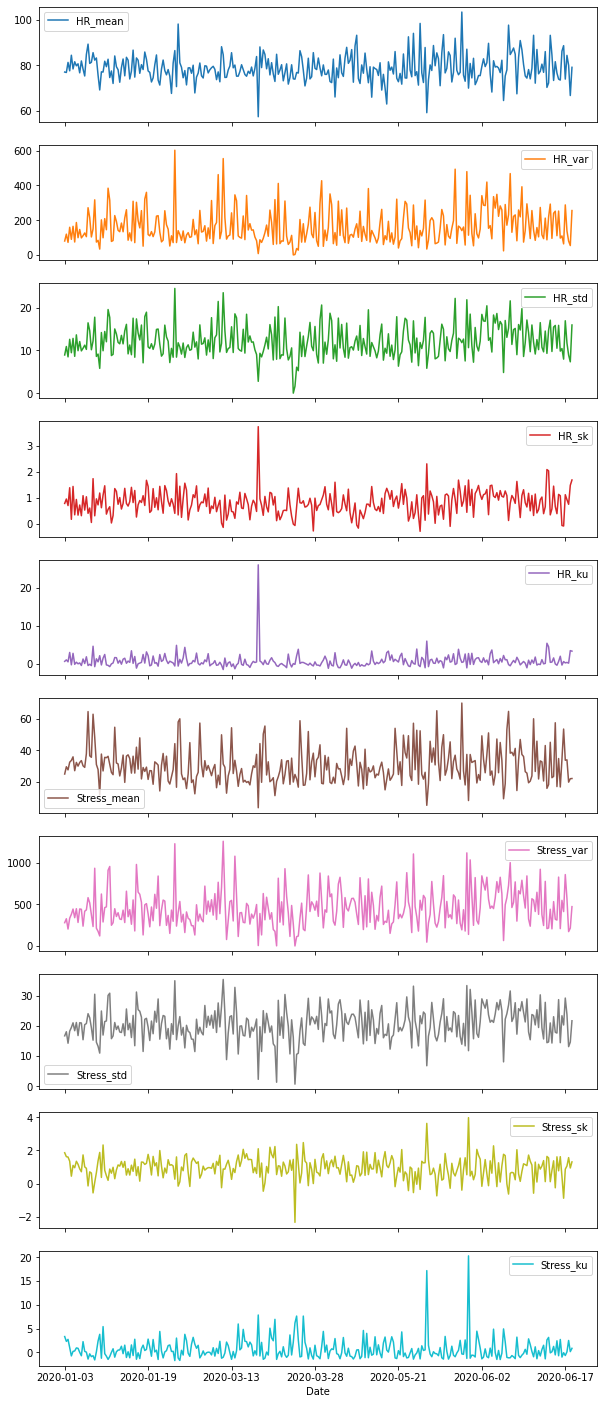

In [ ]:
# Visualize R class samples
master_file_R.plot(subplots=True, figsize=(10, 25))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0716088b0>,
      dtype=object)

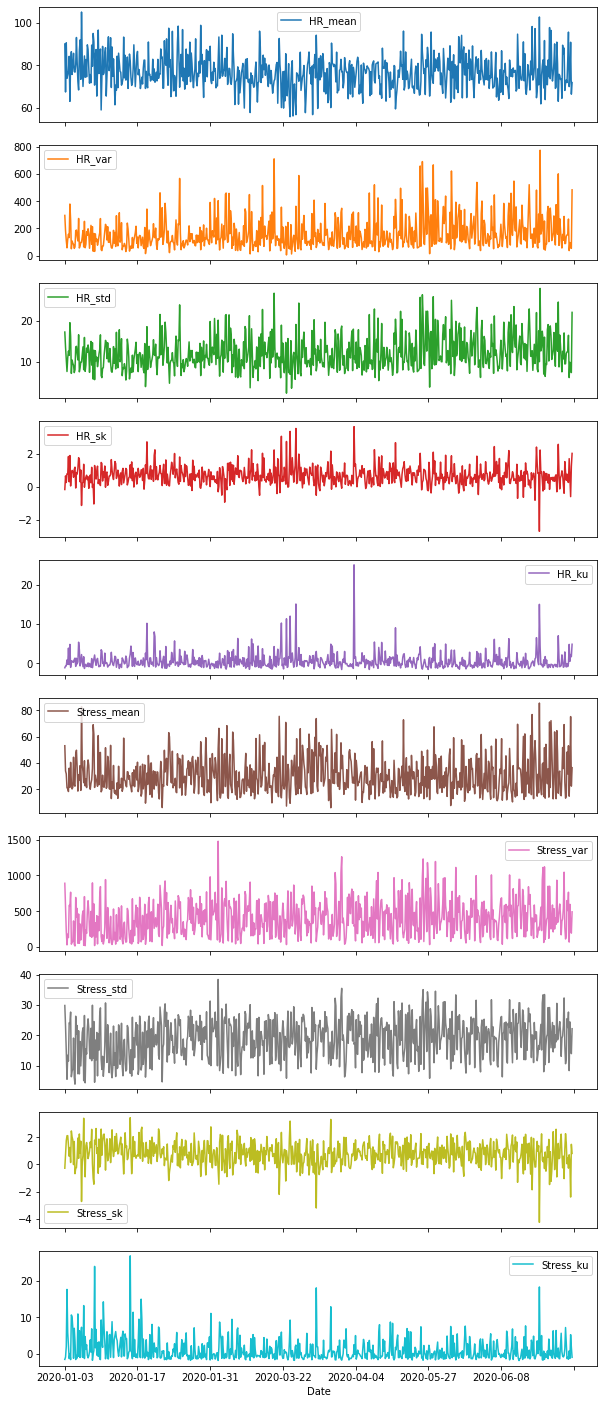

In [ ]:
# Visualize NR class samples
master_file_NR.plot(subplots=True, figsize=(10, 25))

The above visualization shows the time series distribution of each variable. This clearly shows the difference in the number of samples for classes R and NR.

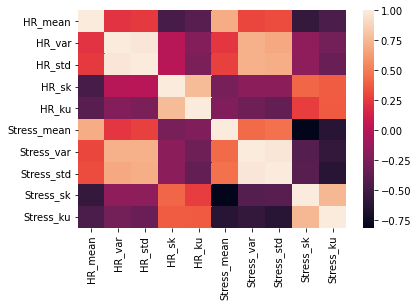

In [ ]:
# Generate correlation matrix for R class
cormat = master_file_R.corr()
sns.heatmap(cormat);

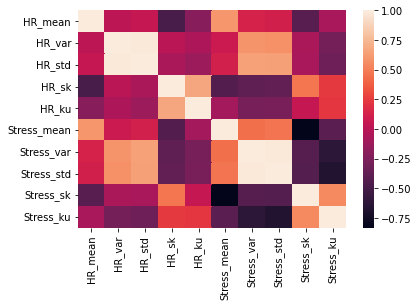

In [ ]:
# Generate correlation matrix for NR class
cormat = master_file_NR.corr()
sns.heatmap(cormat);

Due to the proportion of variables to samples, no feature will be dropped for the ML model.

## **MODELS**

### **LONG SHORT-TERM MEMORY (ML MODEL)**

LSTM is a variety of recurrent neural networks (RNN) that is capable of learning long-term dependencies, especially in sequence predictin problems. It is well used in speech recognition, machine translation, and stock market predction. 

Due to the unequal distribution of the samples R and NR class datasets as well as the arrangement of their dates, it will be almost impossible to train and forecast sequential samples belonging to a particular sample set if all datasets are concatenated. This is why this report runs LSTM on individual sample batches within which the samples are sequential and belong to a particular sample group(S1, S2, & S3).

Unfortunately, due to the batch processing of the datasets, only few samples are available per sample group (Max=90). Therefore, validation is used as a means to test the performance of the model.

Each model trains a varying number of samples, then forecasts one(1) past sample(moving window). The results are then plotted to show the relationship between train and validation performance.

#### **R-CLASS**

Since the sample batch with the lowest sample size is 19(Daily_2088), the moving window as 18-1 the model is set so model trains on eighteen(18th) samples, then validates the nineteenth(19th).

##### **R-CLASS: DAILY_2009 S1 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2009 = concat_files(path_R, file_list_R[:3], '.csv', 0)

# Save only needed columns in new variable
daily_2009 = pd.concat([daily_2009.iloc[ :, [0]], daily_2009.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2009.set_index('Date', inplace=True)

# Train-test split
df_train_val = daily_2009

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features.

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 18  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (58, 18, 10).
trainY shape == (58, 1).


In [ ]:
# Define the Autoencoder model
model_r1 = Sequential()

model_r1.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_r1.add(LSTM(32, activation='relu', return_sequences=False))
model_r1.add(Dropout(0.2))
model_r1.add(Dense(trainY.shape[1]))

model_r1.compile(optimizer='adam', loss='mse')
model_r1.summary()

# Fit the model
history = model_r1.fit(trainX, trainY, epochs=85, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 18, 64)            19200     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/85
4/4 [==============================] - 4s 172ms/step - loss: 1.0527 - val_loss: 1.3658
Epoch 2/85
4/4 [==============================] - 0s 34ms/step - loss: 1.0268 - val_lo

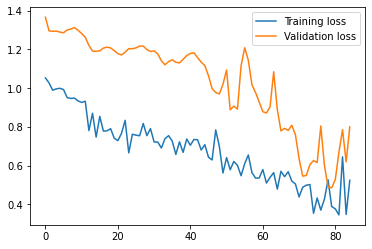

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

##### **R-CLASS: DAILY_2027 S1 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2027 = concat_files(path_R, file_list_R[3:6], '.csv', 0)

# Save only needed columns in new variable
daily_2027 = pd.concat([daily_2027.iloc[ :, [0]], daily_2027.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2027.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2027

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (73, 14, 10).
trainY shape == (73, 1).


In [ ]:
# Define the Autoencoder model
model_r2 = Sequential()

model_r2.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_r2.add(LSTM(32, activation='relu', return_sequences=False))
model_r2.add(Dropout(0.2))
model_r2.add(Dense(trainY.shape[1]))

model_r2.compile(optimizer='adam', loss='mse')
model_r2.summary()

# Fit the model
history = model_r2.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 64)            19200     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5/5 [==============================] - 3s 110ms/step - loss: 1.1081 - val_loss: 1.5412
Epoch 2/10
5/5 [==============================] - 0s 23ms/step - loss: 1.0553 - val_

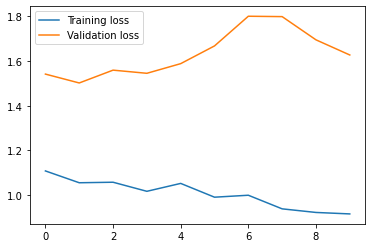

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

##### **R-CLASS: DAILY_2060 S1 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2060 = concat_files(path_R, file_list_R[6:9], '.csv', 0)

# Save only needed columns in new variable
daily_2060 = pd.concat([daily_2060.iloc[ :, [0]], daily_2060.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2060.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2060

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 16  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (46, 16, 10).
trainY shape == (46, 1).


In [ ]:
# Define the Autoencoder model
model_r3 = Sequential()

model_r3.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_r3.add(LSTM(32, activation='relu', return_sequences=False))
model_r3.add(Dropout(0.2))
model_r3.add(Dense(trainY.shape[1]))

model_r3.compile(optimizer='adam', loss='mse')
model_r3.summary()

# Fit the model
history = model_r3.fit(trainX, trainY, epochs=70, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 16, 64)            19200     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70
3/3 [==============================] - 3s 210ms/step - loss: 0.9108 - val_loss: 1.6324
Epoch 2/70
3/3 [==============================] - 0s 29ms/step - loss: 0.8166 - val_

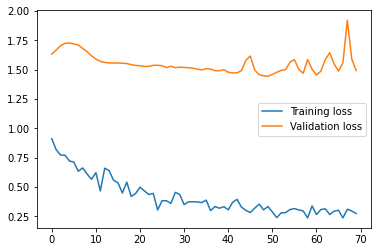

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

##### **R-CLASS: DAILY_2061 S1 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2061 = concat_files(path_R, file_list_R[9:12], '.csv', 0)

# Save only needed columns in new variable
daily_2061 = pd.concat([daily_2061.iloc[ :, [0]], daily_2061.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2061.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2061

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 16  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (45, 16, 10).
trainY shape == (45, 1).


In [ ]:
# Define the Autoencoder model
model_r4 = Sequential()

model_r4.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_r4.add(LSTM(32, activation='relu', return_sequences=False))
model_r4.add(Dropout(0.2))
model_r4.add(Dense(trainY.shape[1]))

model_r4.compile(optimizer='adam', loss='mse')
model_r4.summary()

# Fit the model
history = model_r4.fit(trainX, trainY, epochs=15, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 16, 64)            19200     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
3/3 [==============================] - 3s 223ms/step - loss: 1.2184 - val_loss: 0.8940
Epoch 2/15
3/3 [==============================] - 0s 31ms/step - loss: 1.2046 - val_

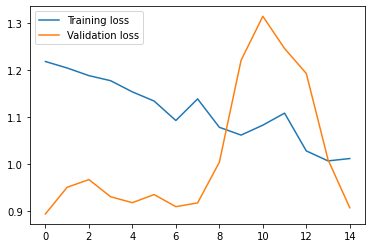

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

##### **R-CLASS: DAILY_2088 S2 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2088 = concat_files(path_R, file_list_R[12:], '.csv', 0)

# Save only needed columns in new variable
daily_2088 = pd.concat([daily_2088.iloc[ :, [0]], daily_2088.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2088.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2088

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 9  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (10, 9, 10).
trainY shape == (10, 1).


In [ ]:
# Define the Autoencoder model
model_r5 = Sequential()

model_r5.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_r5.add(LSTM(32, activation='relu', return_sequences=False))
model_r5.add(Dropout(0.2))
model_r5.add(Dense(trainY.shape[1]))

model_r5.compile(optimizer='adam', loss='mse')
model_r5.summary()

# Fit the model
history = model_r5.fit(trainX, trainY, epochs=15, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 9, 64)             19200     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
1/1 [==============================] - 6s 6s/step - loss: 1.6054 - val_loss: 0.3288
Epoch 2/15
1/1 [==============================] - 0s 112ms/step - loss: 1.5754 - val_lo

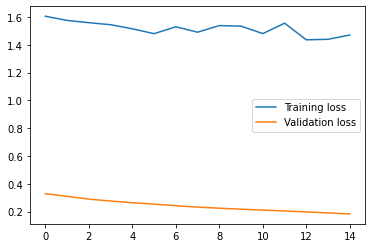

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#### **NR-CLASS**

##### **NR-CLASS: DAILY_2002 S1 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2002 = concat_files(path_NR, file_list_NR[:3], '.csv', 0)

# Save only needed columns in new variable
daily_2002 = pd.concat([daily_2002.iloc[ :, [0]], daily_2002.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2002.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2002

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 18  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (68, 18, 10).
trainY shape == (68, 1).


In [ ]:
# Define the Autoencoder model
model_nr1 = Sequential()

model_nr1.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_nr1.add(LSTM(32, activation='relu', return_sequences=False))
model_nr1.add(Dropout(0.2))
model_nr1.add(Dense(trainY.shape[1]))

model_nr1.compile(optimizer='adam', loss='mse')
model_nr1.summary()

# Fit the model
history = model_nr1.fit(trainX, trainY, epochs=30, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 18, 64)            19200     
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
4/4 [==============================] - 6s 222ms/step - loss: 1.0995 - val_loss: 0.7932
Epoch 2/30
4/4 [==============================] - 0s 29ms/step - loss: 0.9507 - val_

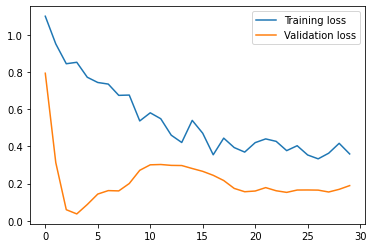

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

##### **NR-CLASS: DAILY_2018 S1 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2018 = concat_files(path_NR, file_list_NR[3:6], '.csv', 0)

# Save only needed columns in new variable
daily_2018 = pd.concat([daily_2018.iloc[ :, [0]], daily_2018.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2018.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2018

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 18  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (62, 18, 10).
trainY shape == (62, 1).


In [ ]:
# Define the Autoencoder model
model_nr2 = Sequential()

model_nr2.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_nr2.add(LSTM(32, activation='relu', return_sequences=False))
model_nr2.add(Dropout(0.2))
model_nr2.add(Dense(trainY.shape[1]))

model_nr2.compile(optimizer='adam', loss='mse')
model_nr2.summary()

# Fit the model
history = model_nr2.fit(trainX, trainY, epochs=19, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 18, 64)            19200     
                                                                 
 lstm_13 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/19
4/4 [==============================] - 3s 152ms/step - loss: 0.6473 - val_loss: 4.9025
Epoch 2/19
4/4 [==============================] - 0s 27ms/step - loss: 0.5719 - val_

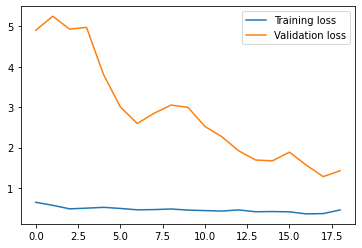

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

##### **NR-CLASS: DAILY_2029 S1 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2029 = concat_files(path_NR, file_list_NR[6:9], '.csv', 0)

# Save only needed columns in new variable
daily_2029 = pd.concat([daily_2029.iloc[ :, [0]], daily_2029.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2029.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2029

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 18  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (55, 18, 10).
trainY shape == (55, 1).


In [ ]:
# Define the Autoencoder model
model_nr3 = Sequential()

model_nr3.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_nr3.add(LSTM(32, activation='relu', return_sequences=False))
model_nr3.add(Dropout(0.2))
model_nr3.add(Dense(trainY.shape[1]))

model_nr3.compile(optimizer='adam', loss='mse')
model_nr3.summary()

# Fit the model
history = model_nr3.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_14 (LSTM)              (None, 18, 64)            19200     
                                                                 
 lstm_15 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
4/4 [==============================] - 3s 153ms/step - loss: 0.9160 - val_loss: 1.2936
Epoch 2/20
4/4 [==============================] - 0s 29ms/step - loss: 0.8858 - val_

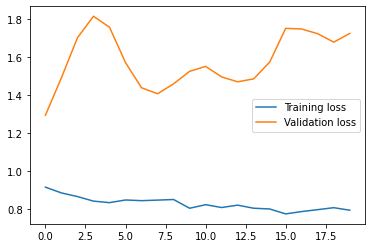

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

##### **NR-CLASS: DAILY_2052 S1 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2052 = concat_files(path_NR, file_list_NR[9:12], '.csv', 0)

# Save only needed columns in new variable
daily_2052 = pd.concat([daily_2052.iloc[ :, [0]], daily_2052.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2052.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2052

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 18  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (69, 18, 10).
trainY shape == (69, 1).


In [ ]:
# Define the Autoencoder model
model_nr4 = Sequential()

model_nr4.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_nr4.add(LSTM(32, activation='relu', return_sequences=False))
model_nr4.add(Dropout(0.2))
model_nr4.add(Dense(trainY.shape[1]))

model_nr4.compile(optimizer='adam', loss='mse')
model_nr4.summary()

# Fit the model
history = model_nr4.fit(trainX, trainY, epochs=18, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 18, 64)            19200     
                                                                 
 lstm_17 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/18
4/4 [==============================] - 3s 152ms/step - loss: 1.0238 - val_loss: 0.2147
Epoch 2/18
4/4 [==============================] - 0s 29ms/step - loss: 0.9214 - val_

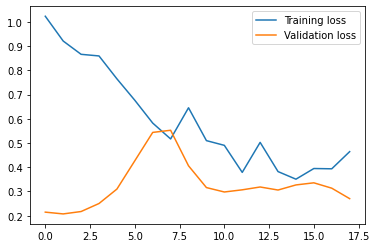

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

##### **NR-CLASS: DAILY_2057 S1 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2057 = concat_files(path_NR, file_list_NR[12:15], '.csv', 0)

# Save only needed columns in new variable
daily_2057 = pd.concat([daily_2057.iloc[ :, [0]], daily_2057.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2057.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2057

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 18  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (69, 18, 10).
trainY shape == (69, 1).


In [ ]:
# Define the Autoencoder model
model_nr5 = Sequential()

model_nr5.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_nr5.add(LSTM(32, activation='relu', return_sequences=False))
model_nr5.add(Dropout(0.2))
model_nr5.add(Dense(trainY.shape[1]))

model_nr5.compile(optimizer='adam', loss='mse')
model_nr5.summary()

# Fit the model
history = model_nr5.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 18, 64)            19200     
                                                                 
 lstm_19 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
4/4 [==============================] - 3s 170ms/step - loss: 0.7635 - val_loss: 0.9502
Epoch 2/20
4/4 [==============================] - 0s 28ms/step - loss: 0.6730 - val_

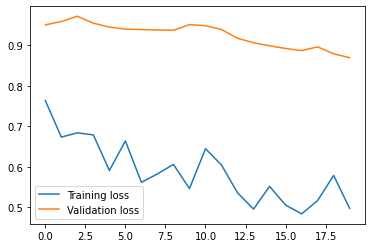

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

##### **NR-CLASS: DAILY_2065 S1 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2065 = concat_files(path_NR, file_list_NR[15:18], '.csv', 0)

# Save only needed columns in new variable
daily_2065 = pd.concat([daily_2065.iloc[ :, [0]], daily_2065.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2065.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2065

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 18  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (62, 18, 10).
trainY shape == (62, 1).


In [ ]:
# Define the Autoencoder model
model_nr6 = Sequential()

model_nr6.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_nr6.add(LSTM(32, activation='relu', return_sequences=False))
model_nr6.add(Dropout(0.2))
model_nr6.add(Dense(trainY.shape[1]))

model_nr6.compile(optimizer='adam', loss='mse')
model_nr6.summary()

# Fit the model
history = model_nr6.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 18, 64)            19200     
                                                                 
 lstm_21 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
4/4 [==============================] - 3s 162ms/step - loss: 0.6973 - val_loss: 0.9381
Epoch 2/20
4/4 [==============================] - 0s 31ms/step - loss: 0.6698 - val

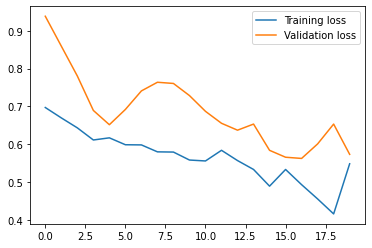

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

##### **NR-CLASS: DAILY_2068 S1 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2068 = concat_files(path_NR, file_list_NR[18:21], '.csv', 0)

# Save only needed columns in new variable
daily_2068 = pd.concat([daily_2068.iloc[ :, [0]], daily_2068.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2068.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2068

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 18  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (43, 18, 10).
trainY shape == (43, 1).


In [ ]:
# Define the Autoencoder model
model_nr7 = Sequential()

model_nr7.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_nr7.add(LSTM(32, activation='relu', return_sequences=False))
model_nr7.add(Dropout(0.2))
model_nr7.add(Dense(trainY.shape[1]))

model_nr7.compile(optimizer='adam', loss='mse')
model_nr7.summary()

# Fit the model
history = model_nr7.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 18, 64)            19200     
                                                                 
 lstm_23 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
3/3 [==============================] - 3s 259ms/step - loss: 0.8370 - val_loss: 0.0817
Epoch 2/20
3/3 [==============================] - 0s 44ms/step - loss: 0.7426 - val

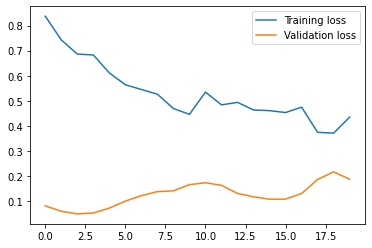

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

##### **NR-CLASS: DAILY_2080 S1 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2080 = concat_files(path_NR, file_list_NR[18:21], '.csv', 0)

# Save only needed columns in new variable
daily_2080 = pd.concat([daily_2080.iloc[ :, [0]], daily_2080.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2080.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2080

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 19  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (42, 19, 10).
trainY shape == (42, 1).


In [ ]:
# Define the Autoencoder model
model_nr8 = Sequential()

model_nr8.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_nr8.add(LSTM(32, activation='relu', return_sequences=False))
model_nr8.add(Dropout(0.2))
model_nr8.add(Dense(trainY.shape[1]))

model_nr8.compile(optimizer='adam', loss='mse')
model_nr8.summary()

# Fit the model
history = model_nr8.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 19, 64)            19200     
                                                                 
 lstm_25 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
3/3 [==============================] - 3s 223ms/step - loss: 0.7510 - val_loss: 0.0595
Epoch 2/5
3/3 [==============================] - 0s 32ms/step - loss: 0.6688 - val_l

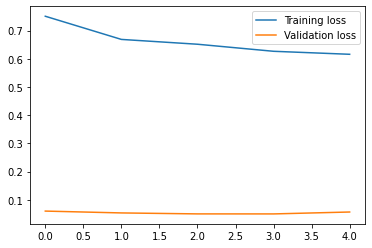

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

##### **NR-CLASS: DAILY_2087 S2 - S3**

In [ ]:
# Concatenate files from only specified datasets
daily_2087 = concat_files(path_NR, file_list_NR[21:], '.csv', 0)

# Save only needed columns in new variable
daily_2087 = pd.concat([daily_2087.iloc[ :, [0]], daily_2087.iloc[:, -10:]], axis=1, join='inner')

# Set the index
daily_2087.set_index('Date', inplace=True)

# Train-text split
df_train_val = daily_2087

<ipython-input-3-276a33b44c2e>:26: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  temp_file = pd.concat([temp_file, data], axis, ignore_index = True)


In [ ]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_train_val)
df_for_training_scaled = scaler.transform(df_train_val)

# As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
# In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

# Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 19  # Number of past days we want to use to predict the future.

In [ ]:
# Reformat input data into a shape: (n_samples x timesteps x n_features)
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_train_val.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

# Make the data numpy array
trainX, trainY = np.array(trainX), np.array(trainY)

# Print data
print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (126, 19, 10).
trainY shape == (126, 1).


In [ ]:
# Define the Autoencoder model
model_nr9 = Sequential()

model_nr9.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model_nr9.add(LSTM(32, activation='relu', return_sequences=False))
model_nr9.add(Dropout(0.2))
model_nr9.add(Dense(trainY.shape[1]))

model_nr9.compile(optimizer='adam', loss='mse')
model_nr9.summary()

# Fit the model
history = model_nr9.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_26 (LSTM)              (None, 19, 64)            19200     
                                                                 
 lstm_27 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_13 (Dropout)        (None, 32)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 31,649
Trainable params: 31,649
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
8/8 [==============================] - 3s 81ms/step - loss: 1.0317 - val_loss: 0.6910
Epoch 2/5
8/8 [==============================] - 0s 26ms/step - loss: 0.9507 - val_lo

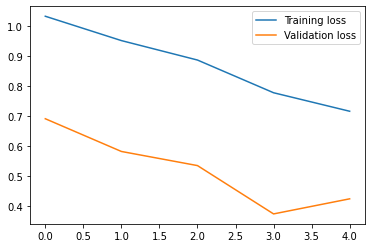

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

### **VECTOR AUTO-REGRESSIVE MODEL**

Most traditional forecasting models are built for handling univariate datasets. This include Moving Average, Exponential Smoothing, etc. This means they can not handle the dimensionally of this dataset. Therefore, VAR is used instead. VAR is a statistical model used to capture the relationship between multiple quantities as they change over time.

Due to the amount of computational resource needed to compute VAR models and multivariate data sets, a single sample set that yeilded good results with the ML model was used. The result was then ploted.


In [ ]:
#@title
df_iq_iz=daily_2088
# Make dataset stationary by substracting each value from its previous value
for i in range(len(df_iq_iz.columns)):
  result = adfuller(df_iq_iz[df_iq_iz.columns[i]])
  if result[1] > 0.05:
    print('{} - Series is not stationary'.format(df_iq_iz.columns[i]))
  else:
    print('{} - Series is stationary'.format(df_iq_iz.columns[i]))

The above results shows that some of the features of the dataset are stable while others are not. Note that this is not an exhaustive measure to check the stationarity of the features. Multiple tests and visualizations can be used to validate these results(e.g., apss testing)

In [ ]:
#@title
# Random split data to train and test
df_iq_iz_train = master_file_R[:int(0.9*(len(master_file_R)))]
df_iq_iz_test = master_file_R[int(0.9*(len(master_file_R))):]

In [ ]:
#@title
df_iq_iz_train.shape

In [ ]:
#@title
df_iq_iz_test.shape

In [ ]:
#@title
# Create VAR model
model = VAR(df_iq_iz_train.diff()[1:])

In [ ]:
#@title
# Looking for minumum AIC
sorted_order=model.select_order(maxlags=20)
print(sorted_order.summary())

In [ ]:
#@title
# Fit VARMAX model to improve prediction
var_model = VARMAX(df_iq_iz_train, order=(4,0),enforce_stationarity= True)
fitted_model = var_model.fit(disp=False)
print(fitted_model.summary())

In [ ]:
#@title
# Forecast test data
n_forecast = 101
predict = fitted_model.get_prediction(start=len(df_iq_iz_train),end=len(df_iq_iz_train) + n_forecast-1)

predictions=predict.predicted_mean
predictions

In [ ]:
#@title
predictions.columns=['HR_mean_predicted',	'HR_var_predicted',	'HR_std_predicted',	'HR_sk_predicted',	'HR_ku_predicted',	'Stress_mean_predicted',	'Stress_var_predicted',	'Stress_std_predicted',	'Stress_sk_predicted',	'Stress_ku_predicted']
predictions = predictions.reset_index(drop=True)
predictions

In [ ]:
#@title
df_iq_iz_test = df_iq_iz_test.reset_index()

In [ ]:
#@title
test_vs_pred=pd.concat([df_iq_iz_test, predictions],axis=1)
test_vs_pred.set_index('Date', inplace=True)
test_vs_pred

In [ ]:
#@title
test_vs_pred.plot(figsize=(18,7))

## **CONCLUSION**

**Stationarity** is a property that describes when the mean, variance, and autocorrelation structure of data do not change over time. Statistical models do not do well with non-stationary data, and this can be seen in the performance of features such as 'Stress_var' where VAR performed poorly.

In general, the LSTM's performance was average, but this can be as a result of the low number of samples used to train the dataset.